In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Modeling the low-pass filter

The idea is that we have a circuit like so:

![Op Amp Low Pass Filter](opamp_circuit_small.png)

This is an RC circuit followed by a $x2$ amplifier. First consider the RC portion. It's like a voltage divider! If you replaced the $C$ with an $R_2$ you'd simply apply Ohm's Law to compute the current:

$$I =\frac{V_{in}}{R + R_2}$$

And compute the voltage accross $R_2$ of:

$$V_2 = R_2 I = R_2 \frac{V_{in}}{R + R_2}$$

But this case is very similar: The AC reactance of the capacitor is:

$$X_C = \frac{1}{\omega C}$$

The *impedance* of the series combination of $X_C$ and $R$ is:

$$ Z = \sqrt{R^2 + X_C^2} $$ 

since the voltage accross the resistor is $90^\circ$ out of phase with the voltage accross the capacitor.

The current through the RC combination is:

$$ I = V_{in}/Z $$

The voltage accross the capacitor is just:

$$V_C = X_C I = X_C \frac{V_{in}}{Z}$$

The *gain* is $V_C/V_{in}$ or:

$$G = \frac{V_C}{V_{in}} = \frac{X_C}{Z}$$

Now, what happens when you add a $x2$ amplifier after the RC circuit (as in part-2 of project 3)?

Then there's an overall gain of:

$$ G = 2 \frac{X_C}{Z}$$

However, if we put in expressions for $X_C$ and $Z$ we can simplify this:

$$ G = 2 \frac{X_C}{Z} = \frac{2 X_C}{\sqrt{R^2 + X_C^2}} = \frac{2}{\sqrt{1 + (\omega R C)^2}}$$

Finally if we define $\omega_0 = 1/(RC)$ then this simplfies to:

$$ G = \frac{2}{\sqrt{1 + (\omega/\omega_0)^2}}$$

Nice!


RC= 1.65e-04 sec
omega0 = 6.06e+03 rad/sec
f0 = 9.65e+02 Hz


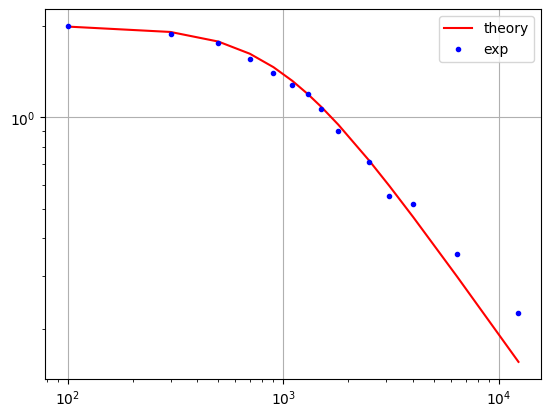

In [2]:
#
# Here's some sample data from a student lab. 
#
# f is linear frequency, g is measured "gain".
#
# You can use this idea: 
#
#        But use your own data! (R, C, f, g)
#

f = np.array([100, 300, 500, 700, 900, 1100, 
     1300, 1500, 1800, 2500, 3100, 
     4000, 6400, 12300])

g = np.array([2,1.88,1.7575,1.5606,1.3939,
     1.2813,1.1935,1.0645,.9032,
     .7097,.5484,.5161,.3548,.2258])

omega = 2*np.pi*np.array(f)

R=500
C=0.33e-6

omega0 = 1/(R*C) #as above

print("RC= %5.2e sec" % (R*C))
print("omega0 = %5.2e rad/sec" % omega0)
print("f0 = %5.2e Hz" % (omega0/(2*np.pi)))

#
# Let's compute the theoretical gain
#

Gth = 2.0/np.sqrt(1 + (omega/omega0)**2)

plt.loglog(f,Gth,'r-',label='theory')
plt.loglog(f,g,'b.',label='exp')
plt.grid()
plt.legend()

This looks good! For the purposes of the project 3 report, this approach will be sufficient. 

However, I'd like to take also point out that we'll be learning a tool for Bayesian inference to find the posterior distribution of the gain and break frequency based on the data that was measured. The tool we'll be using is call [PyMC](https://www.pymc.io/welcome.html). Here's an example of how PyMC can infer both the gain and the break frequency based on the data provided.

In [3]:
def output(f, G0, omega0):
    """
    this is the theoretical output amplitude, without measurement noise.
    """
    omega = 2*np.pi*f
    return G0*1.0/np.sqrt((1.0+(omega/omega0)**2))

with pm.Model() as low_pass_model:
    G0 = pm.Uniform('G0',0,10)      # what is the prior distribution of the Gain?
    f0 = pm.Uniform('f0',200,2000)  # what is the prior distribution of the break frequency?
    sigma = pm.Uniform('sigma',0,1) # what is the proper prior distribution of the noise?
    
    Aout = pm.Normal('out',mu=output(f,G0,2*np.pi*f0), sigma=sigma, observed=g) # what is the observed data?
    trace = pm.sample(2000, return_inferencedata=True) # sample 2000 times from the posterior distribution
    

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


,mean,sd,hdi_3%,hdi_97%
G0,1.978,0.031,1.917,2.036
f0,952.145,35.113,888.020,1021.492
sigma,0.045,0.011,0.028,0.065


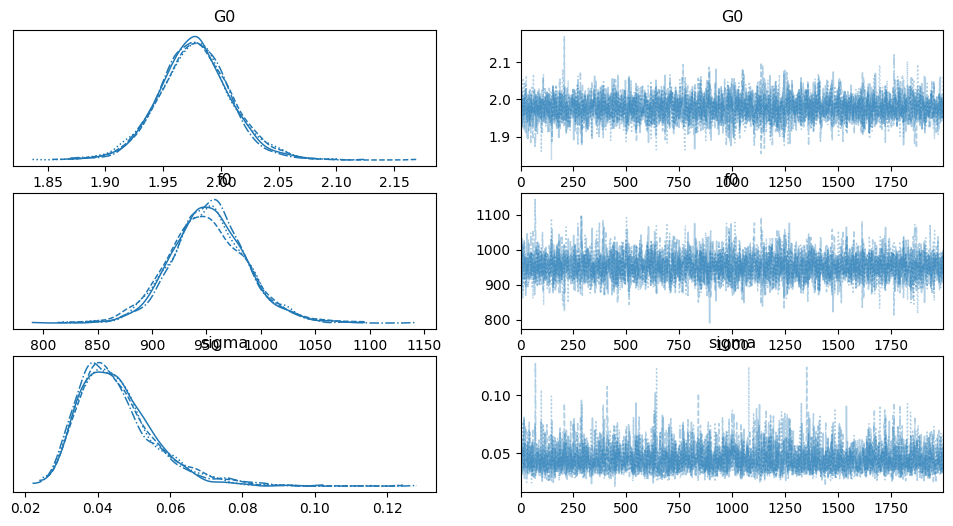

In [4]:
az.plot_trace(trace)
az.summary(trace, kind="stats")

These seem reasonable, but how can we compare against the original data? This is important! We need to valdiate that the model is actually behaving reasonably. This is the point of a posterior predictive check. We sample paramters from the posterior and look at the behavior of the model with those samples.

In [37]:
with low_pass_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['G0','f0','out'])

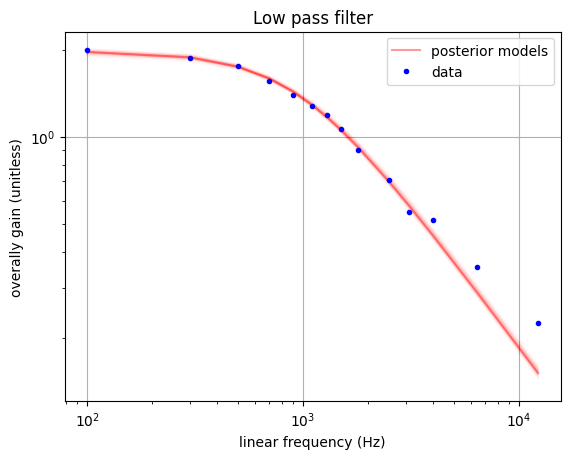

In [49]:

#
# Grab parameters from the posterior distribution and plot a sampling of the models
#

GVals = trace.posterior['G0'][0].values
f0Vals = trace.posterior['f0'][0].values
for j in range(1,200):
    plt.loglog(f,output(f,GVals[j], 2*np.pi*f0Vals[j]), 'r-', alpha=0.005)

plt.loglog(f,output(f,GVals[0], 2*np.pi*f0Vals[0]), 'r-', alpha=0.4, label='posterior models')
    
#
# finally, let's overlay the actual data from the lab, in blue dots.
#

plt.loglog(f,g,'b.', label='data')
plt.grid()
plt.title("Low pass filter")
plt.xlabel("linear frequency (Hz)")
plt.ylabel("overally gain (unitless)")
plt.legend()

In [ ]:
c